In [1]:
#!pip install pyModeS

In [2]:
#!pip install seaborn

In [3]:
import pandas as pd
from pathlib import Path
import pyModeS as pms
from pyModeS import adsb
import base64
import tarfile
from datetime import datetime
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

## Ejercicio 1 b

In [4]:
# Ruta al archivo CSV
path = Path("output_by_day/data_2024-12-01.csv")

# Leer el archivo CSV con Dask
df_horas_1 = dd.read_csv(path)

# Convertir la columna Timestamps a datetime
df_horas_1["Timestamps"] = dd.to_datetime(df_horas_1["Timestamps"])

# Extraer la hora de la columna Timestamps
df_horas_1["Hora"] = df_horas_1["Timestamps"].dt.hour

df_horas_1['type_code'] = df_horas_1.map_partitions(
    lambda df_horas_1: df_horas_1['message'].apply(lambda msg: pms.common.typecode(msg)),
    meta=('message', 'int64') 
)

# Función para determinar la velocidad (Speed)
def determinar_speed(row):
    tc = row['type_code']
    msg = row['message']
    
    if 5 <= tc <= 8:  # Surface position
        v = adsb.surface_velocity(msg)
        if v is not None:
            return v[0]  # Speed en knots
    elif tc == 19:  # Airborne velocity
        velocity = adsb.velocity(msg)
        if velocity is not None:
            return velocity[0]  # Speed en knots
    return None

# Aplicar la función para añadir la columna 'Speed'
df_horas_1['Speed'] = df_horas_1.map_partitions(
    lambda df: df.apply(determinar_speed, axis=1),
    meta=('Speed', 'float64')
)

# Convertir la columna 'Capability' a string y luego a booleano en cada partición
df_horas_1['Capability'] = df_horas_1.map_partitions(
    lambda df: df['Capability'].astype(str).map({'True': True, 'False': False}),
    meta=('Capability', 'bool')
)

df_horas_1.head()

,ts_kafka,message,ICAO,Capability,Timestamps,Speed,Track,Vertical rate,Hora,type_code
0,1733011203260,8d4a1922ea428858013c08f2909e,4a1922,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,29.0
1,1733011203260,a000149658a562604860f0c3b5e7,34640E,NaN,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN
2,1733011203260,a0001910c309e531203fffe4c948,4CADA4,NaN,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN
3,1733011203260,8d02012bf82300020049b87682df,02012b,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,31.0
4,1733011203260,5d3442135415f7,344213,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN


In [5]:
df = df_horas_1.compute()
df

,ts_kafka,message,ICAO,Capability,Timestamps,Speed,Track,Vertical rate,Hora,type_code
0,1733011203260,8d4a1922ea428858013c08f2909e,4a1922,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,29.0
1,1733011203260,a000149658a562604860f0c3b5e7,34640E,NaN,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN
2,1733011203260,a0001910c309e531203fffe4c948,4CADA4,NaN,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN
3,1733011203260,8d02012bf82300020049b87682df,02012b,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,31.0
4,1733011203260,5d3442135415f7,344213,True,2024-12-01 00:00:03,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
891787,1733084001652,8d34538e990d15a6383c1a561fd2,34538e,True,2024-12-01 20:13:21,410.0,NaN,NaN,20,19.0
891788,1733084001652,8c34134d3a7a03f8486ec476f732,34134d,False,2024-12-01 20:13:21,15.0,90.0,0.0,20,7.0
891789,1733084001652,a0001718c65632b0a80000715f36,407CB0,NaN,2024-12-01 20:13:21,NaN,NaN,NaN,20,NaN
891790,1733084001652,5d495213f22ad1,495213,True,2024-12-01 20:13:21,NaN,NaN,NaN,20,NaN


In [6]:
# Ordenar por aeronave y tiempo
df = df.sort_values(by=['ICAO', 'Timestamps'])

# Lista para almacenar tiempos de espera y horas
tiempos_espera = []
horas_espera = []

# Recorrer cada hora
for hora, grupo_hora in df.groupby(df['Timestamps'].dt.hour):
    # Recorrer cada aeronave dentro de la hora
    for icao, grupo in grupo_hora.groupby('ICAO'):
        # Filtrar mensajes en tierra (Capability == False y Speed == 0)
        tierra = grupo[(grupo["Capability"] == False) & (grupo["Speed"] == 0)]
        
        # Filtrar mensajes en vuelo (Capability == True y Speed > 0)
        vuelo = grupo[(grupo['Capability'] == True) & (grupo["Speed"] > 0)]

        # Si no hay suficientes datos, continuar con la siguiente aeronave
        if tierra.empty or vuelo.empty:
            continue

        # Recorrer los mensajes en tierra
        for idx, fila_tierra in tierra.iterrows():
            # Buscar el primer mensaje en vuelo después del mensaje en tierra
            primer_vuelo = vuelo[vuelo['Timestamps'] > fila_tierra['Timestamps']].head(1)
            
            if not primer_vuelo.empty:
                # Calcular el tiempo de espera
                tiempo_espera = (primer_vuelo['Timestamps'].iloc[0] - fila_tierra['Timestamps']).total_seconds()
                
                # Almacenar el tiempo de espera y la hora del evento en tierra
                if tiempo_espera > 0:
                    tiempos_espera.append(tiempo_espera)
                    horas_espera.append(hora)

# Convertir a DataFrame
df_espera = pd.DataFrame({'Tiempo de espera': tiempos_espera, 'Hora': horas_espera})

# Mostrar el DataFrame resultante
df_espera

,Tiempo de espera,Hora
0,808.0,0
1,808.0,0
2,802.0,0
3,545.0,0
4,461.0,0
...,...,...
32915,50.0,20
32916,40.0,20
32917,35.0,20
32918,30.0,20


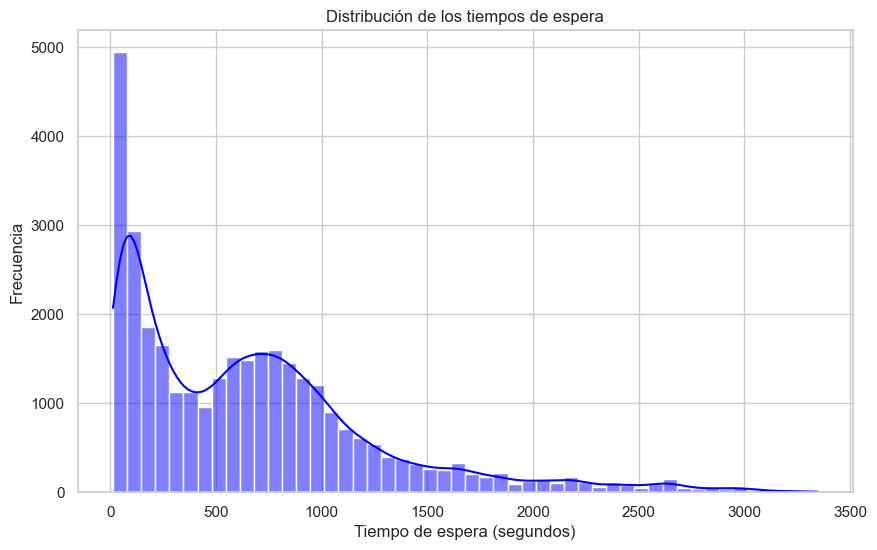

In [9]:
# Configurar el estilo de las gráficas
sns.set(style="whitegrid")

# **Histograma**
plt.figure(figsize=(10, 6))
sns.histplot(df_espera['Tiempo de espera'], bins=50, kde=True, color='blue')
plt.xlabel('Tiempo de espera (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de los tiempos de espera')
plt.show()

### Análisis del Histograma de Tiempos de Espera

1. **Asimetría positiva (sesgo a la derecha)**  
   - La mayoría de los datos están en valores bajos, con una larga cola hacia la derecha.  
   - Indica que algunos tiempos de espera son muy altos, pero poco frecuentes.

2. **Distribución sesgada**  
   - La media probablemente es mayor que la mediana debido a los valores extremos.  


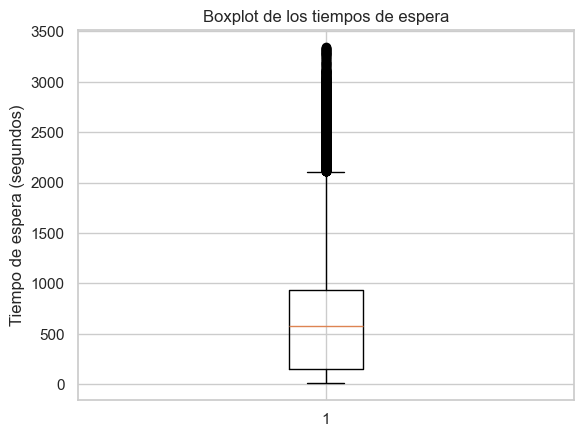

In [11]:
# Boxplot de los tiempos de espera
plt.boxplot(df_espera['Tiempo de espera'])
plt.title('Boxplot de los tiempos de espera')
plt.ylabel('Tiempo de espera (segundos)')
plt.show()

El boxplot muestra que la mayoría de los tiempos de espera son muy cortos, pero hay algunos casos en los que los tiempos de espera son significativamente mayores. La larga cola de valores atípicos a la derecha sugiere que la distribución de los tiempos de espera está sesgada hacia la derecha. Esto significa que la media de los tiempos de espera será mayor que la mediana.

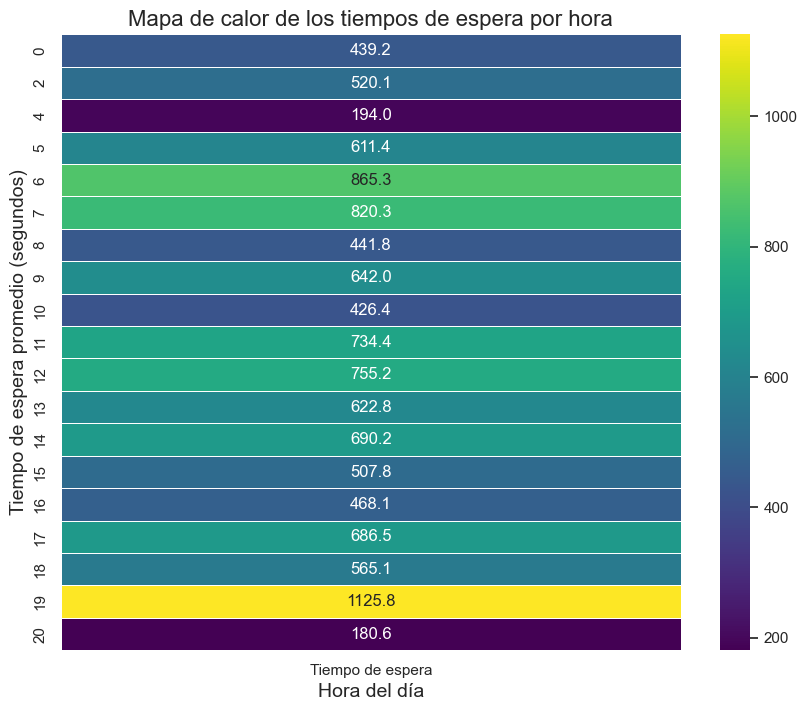

In [13]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Mapa de calor de los tiempos de espera por hora
heatmap_data = df_espera.groupby('Hora')['Tiempo de espera'].mean().reset_index()
heatmap_data = heatmap_data.pivot_table(index='Hora', values='Tiempo de espera', aggfunc='mean')

# Crear el mapa de calor con anotaciones
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)

# Añadir título y etiquetas
plt.title('Mapa de calor de los tiempos de espera por hora', fontsize=16)
plt.xlabel('Hora del día', fontsize=14)
plt.ylabel('Tiempo de espera promedio (segundos)', fontsize=14)

# Mostrar el gráfico
plt.show()

# Análisis del Mapa de Calor del Tiempo de Espera por Hora

## 1. Variación Significativa a lo Largo del Día
El mapa de calor muestra una notable variación en los tiempos de espera a lo largo de las 24 horas del día. Esto indica que la demanda o la eficiencia del servicio fluctúan considerablemente.

## 2. Picos de Tiempo de Espera
- Se observa un pico muy alto de tiempo de espera a las **19 horas (7 pm)**, alcanzando los **1125.8 segundos**. Este es el punto más crítico del día.
- También se identifican tiempos de espera elevados en otras horas, aunque no tan extremos, como a las **6, 16, 17 y 18 horas**.

## 3. Tiempos de Espera Moderados
- Durante la mayor parte del día, los tiempos de espera se mantienen en un rango moderado, generalmente entre **400 y 800 segundos**.
- Se puede apreciar que desde las **8 horas hasta las 15 horas**, los tiempos de espera son relativamente estables.

## 4. Patrón Diurno vs. Nocturno
- Existe un patrón claro donde los tiempos de espera tienden a ser **más altos durante la tarde y primeras horas de la noche**, y **más bajos durante la madrugada y primeras horas de la mañana**.
- Se ve que desde las **00 horas hasta las 7 horas**, los tiempos de espera son relativamente bajos.

## 5. Interpretación de los Datos
- El **pico a las 19 horas** podría indicar una **hora de alta demanda**, posiblemente relacionada con el final de la jornada laboral o actividades vespertinas.
- La **baja cantidad de tiempo de espera a las 20 horas** puede significar que a esa hora hay **muy poca demanda del servicio**.
- La **estabilidad durante las horas laborales** podría reflejar una capacidad de servicio adecuada para la demanda promedio.

## 6. Posibles Causas de las Variaciones
- **Fluctuaciones en la demanda del servicio:** La cantidad de personas que requieren el servicio puede variar significativamente a lo largo del día.
- **Disponibilidad de personal o recursos:** La cantidad de personal o recursos disponibles para atender la demanda puede cambiar según la hora.
- **Eventos o factores externos:** Eventos específicos o factores externos, como el tráfico o el clima, podría afectar.